In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import shutil
from google.colab import files

Mounted at /content/drive/


In [ ]:
import cv2
import math
import os
import numpy as np
import pandas as pd
from numpy.ma.core import ceil
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, LSTM, Dropout, Conv2D, GlobalMaxPooling2D, MaxPooling2D, Conv1D, GlobalMaxPooling1D, BatchNormalization, Input, Layer, Lambda
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.regularizers import l2



In [ ]:
data_path = "/content/drive/MyDrive/Location_Season_Data/"


In [ ]:
df = pd.read_csv(data_path + "15x15_data.csv")
# df["Label"].unique()


In [ ]:

table = pd.DataFrame({"Type":["CL", "COH", "COL", "NROI"]})
table["count"] = table["Type"].apply(lambda x: df["Label"].value_counts().get(x, 0))
table

,Type,count
0,CL,859
1,COH,531
2,COL,1225
3,NROI,211


In [ ]:
# train_df_15 = pd.concat([df[df["Day"] <= 1095], df[(df["Day"] > 1460) & (df["Day"] <= 2555)]])
# # Y_features_train = train_df["Class"]
# test_df_15 = pd.concat([df[(df["Day"] > 1095) & (df["Day"] <= 1460)], df[(df["Day"] > 2555) & (df["Day"] <= 2920)]])
# # Y_features_test = test_df["Class"]



In [ ]:
# X_train_15 = train_df_15.drop(columns = ["225", "226", "227", "228", "Month", "Name", "Day", "Class", "Label"])
# Y_train_15 = train_df_15["Class"]

# X_test_15 = test_df_15.drop(columns = ["225", "226", "227", "228", "Month", "Name", "Day", "Class", "Label"])
# Y_test_15 = test_df_15["Class"]
# X = df.drop(columns = ["225", "226", "227", "228", "Month", "Name", "Day", "Class", "Label"])
X = df.drop(columns = ["Name", "Day", "Class", "Label"])
Y = df["Class"]


In [ ]:
#Normalization
def minmax_scaler(data):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    return scaled
#Euclidean distance
def e_distance(x, y):
    return distance.euclidean(x, y)

#Manhanttan distance
def m_distance(x, y):
    return distance.cityblock(x, y)

#Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
  input_data = data[t]
  for row in range(num_rows):
    for col in range(num_cols):
      distance = e_distance(som[row][col], data[t])
      if distance < shortest_distance:
        shortest_distance = distance
        winner = [row,col]
  return winner

#Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_dsitance)
  return learning_rate, neighbourhood_range

In [ ]:
num_rows = 30
num_cols = 30
max_m_dsitance = 8
max_learning_rate = 0.75
max_steps = 100000

In [ ]:
#main function

train_x_norm = minmax_scaler(X) # normalisation
# initialising self-organising map
num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

# start training iterations
for step in range(max_steps):
  if (step+1) % 1000 == 0:
    print("Iteration: ", step+1) # print out the current iteration for every 1k
  learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

  t = np.random.randint(0,high=train_x_norm.shape[0]) # random index of traing data
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  for row in range(num_rows):
    for col in range(num_cols):
      if m_distance([row,col],winner) <= neighbourhood_range:
        som[row][col] += learning_rate*(train_x_norm[t]-som[row][col]) #update neighbour's weight

print("SOM training completed")

Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
Iteration:  11000
Iteration:  12000
Iteration:  13000
Iteration:  14000
Iteration:  15000
Iteration:  16000
Iteration:  17000
Iteration:  18000
Iteration:  19000
Iteration:  20000
Iteration:  21000
Iteration:  22000
Iteration:  23000
Iteration:  24000
Iteration:  25000
Iteration:  26000
Iteration:  27000
Iteration:  28000
Iteration:  29000
Iteration:  30000
Iteration:  31000
Iteration:  32000
Iteration:  33000
Iteration:  34000
Iteration:  35000
Iteration:  36000
Iteration:  37000
Iteration:  38000
Iteration:  39000
Iteration:  40000
Iteration:  41000
Iteration:  42000
Iteration:  43000
Iteration:  44000
Iteration:  45000
Iteration:  46000
Iteration:  47000
Iteration:  48000
Iteration:  49000
Iteration:  50000
Iteration:  51000
Iteration:  52000
Iteration:  53000
Iteration:  54000
Iteration:  55000
Iteration:  56000
I

In [ ]:
label_data = np.array(Y)
map = np.empty(shape=(num_rows, num_cols), dtype=object)

for row in range(num_rows):
  for col in range(num_cols):
    map[row][col] = [] # empty list to store the label

for t in range(train_x_norm.shape[0]):
  if (t+1) % 1000 == 0:
    print("sample data: ", t+1)
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron

sample data:  1000
sample data:  2000


In [ ]:
map_table = {}
for i in range(len(map)):
    for j in range(len(map[0])):
        if len(map[i][j]) == 0:
            map_table[i, j] = [None]
        else:
            hash_table = {}
            for k in map[i][j]:
                if k in hash_table:
                    hash_table[k] += 1
                else:
                    hash_table[k] = 1
            for key, value in hash_table.items():
                percentage = [key, round((value / len(map[i][j])), 2)]
                if (i, j) not in map_table:
                    map_table[i, j] = []
                map_table[i, j].append(percentage)


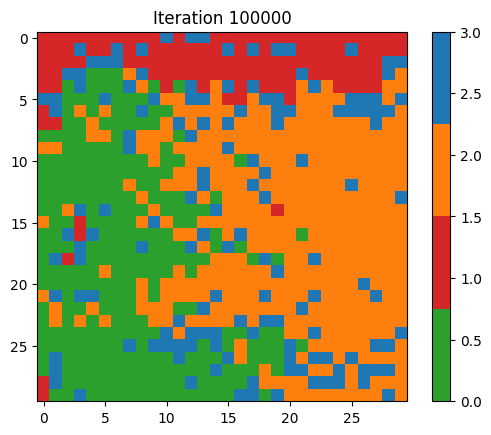

In [ ]:
# construct label map
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
  for col in range(num_cols):
    label_list = map[row][col]
    if len(label_list)==0:
      label = 3
    else:
      label = max(label_list, key=label_list.count)
    label_map[row][col] = label

title = ('Iteration ' + str(max_steps))
cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange', 'tab:blue'])
plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

In [ ]:

# test data

# using the trained som, search the winning node of corresponding to the test data
# get the label of the winning node

data_frame = minmax_scaler(X) # normalisation

winner_labels = []
pre_labels = []

for t in range(data_frame.shape[0]):
  winner = winning_neuron(data_frame, t, som, num_rows, num_cols)
  row = winner[0]
  col = winner[1]
  predicted = label_map[row][col]
  pred = map_table[row, col]
  winner_labels.append(predicted)
  pre_labels.append(pred)

In [ ]:
true_labels = np.array(Y)
predicted_labels = np.array(winner_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

matrix = confusion_matrix(true_labels, predicted_labels)
print(matrix)

Accuracy: 0.8510261854210899
[[ 762    7   89    1]
 [   7  486   31    7]
 [ 103   11 1093   18]
 [  13   44   90   64]]


In [ ]:
test_df = df.copy()
test_df["Pred"] = predicted_labels
test_df["Percentage"] = pre_labels
test_df

,0,1,2,3,4,5,6,7,8,9,...,221,222,223,224,Name,Day,Label,Class,Pred,Percentage
0,0.215782,0.216164,0.217243,0.217349,0.218306,0.217968,0.217241,0.215128,0.213058,0.210526,...,0.255881,0.256841,0.258173,0.259653,2917_c2_cp2_66_11,2917,CL,0,0,"[[0, 0.5], [1, 0.5]]"
1,0.190453,0.191821,0.193863,0.195419,0.197259,0.198331,0.199015,0.198428,0.197349,0.196754,...,0.231397,0.228517,0.226442,0.224903,2910_c1_cp1_98_18,2910,CL,0,0,"[[0, 1.0]]"
2,0.162689,0.162123,0.162202,0.161306,0.161527,0.161512,0.160591,0.159627,0.158076,0.156911,...,0.149784,0.150264,0.150481,0.151062,2908_c1_cp1_79_13,2908,CL,0,0,"[[0, 1.0]]"
3,0.330736,0.324732,0.319045,0.313353,0.309349,0.304369,0.299015,0.292240,0.285714,0.279882,...,0.311090,0.317331,0.323558,0.329151,2908_c4_cp2_21_20,2908,CL,0,0,"[[0, 0.88], [3, 0.12]]"
4,0.149050,0.149464,0.150511,0.151559,0.152227,0.153166,0.153202,0.152750,0.152185,0.151500,...,0.149784,0.151224,0.152885,0.154440,2907_c1_cp1_76_13,2907,CL,0,0,"[[0, 1.0]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2821,0.124208,0.122687,0.122260,0.120858,0.119922,0.118802,0.117241,0.114931,0.112420,0.110182,...,0.116659,0.120499,0.124038,0.128378,2932_c1_cp1_82_13,2932,CL,0,0,"[[0, 1.0]]"
2822,0.431076,0.430867,0.431076,0.430312,0.431229,0.431517,0.431034,0.428782,0.426608,0.425480,...,0.449352,0.458473,0.469231,0.481660,2930_c8_cp2_11_40,2930,COL,2,0,"[[0, 0.6], [2, 0.4]]"
2823,0.476376,0.477118,0.479299,0.481481,0.485560,0.488463,0.491133,0.491159,0.491900,0.492868,...,0.499760,0.497840,0.497115,0.497104,2927_c7_cp2_34_31,2927,COL,2,2,"[[2, 0.83], [0, 0.17]]"
2824,0.492450,0.492697,0.493911,0.495127,0.498287,0.501227,0.503941,0.503929,0.504664,0.506640,...,0.519923,0.524244,0.530288,0.537645,2926_c6_cp2_33_33,2926,COL,2,0,"[[0, 0.67], [2, 0.33]]"


In [ ]:
SOM_label = {"CL": {1:[], 2:[], 3:[]},
"COL":  {1:[], 2:[], 3:[]},
"COH": {1:[], 2:[], 3:[]},
"NROI":  {1:[], 2:[], 3:[]}
}
label_dict = {0: "CL", 1: "COH", 2: "COL", 3: "NROI"}
for i in range(test_df.shape[0]):
    name = test_df["Name"][i]
    percentage = test_df["Percentage"][i]
    for percent in percentage:
        pred = percent[0]
        number = percent[1]
        if number >= 0.5:
            label = label_dict[pred]
            if number >= 0.9:
                SOM_label[label][1].append(name)
            elif number >= 0.75:
                SOM_label[label][2].append(name)
            else:
                SOM_label[label][3].append(name)



In [ ]:
print(len(SOM_label["CL"][1]))
print(len(SOM_label["CL"][2]))
print(len(SOM_label["CL"][3]))


502
156
268


In [ ]:
CL_1_df = test_df[test_df["Name"].isin(SOM_label["CL"][1])]
CL_2_df = test_df[test_df["Name"].isin(SOM_label["CL"][2])]
CL_3_df = test_df[test_df["Name"].isin(SOM_label["CL"][3])]

COL_1_df = test_df[test_df["Name"].isin(SOM_label["COL"][1])]
COL_2_df = test_df[test_df["Name"].isin(SOM_label["COL"][2])]
COL_3_df = test_df[test_df["Name"].isin(SOM_label["COL"][3])]

COH_1_df = test_df[test_df["Name"].isin(SOM_label["COH"][1])]
COH_2_df = test_df[test_df["Name"].isin(SOM_label["COH"][2])]
COH_3_df = test_df[test_df["Name"].isin(SOM_label["COH"][3])]

NROI_1_df = test_df[test_df["Name"].isin(SOM_label["NROI"][1])]
NROI_2_df = test_df[test_df["Name"].isin(SOM_label["NROI"][2])]
NROI_3_df = test_df[test_df["Name"].isin(SOM_label["NROI"][3])]




In [ ]:
CL_1_accuracy = accuracy_score(np.array(CL_1_df["Class"]), np.array(CL_1_df["Pred"]))
CL_1_conf = confusion_matrix(np.array(CL_1_df["Class"]), np.array(CL_1_df["Pred"]))

print(CL_1_accuracy)
print(CL_1_conf)

1.0
[[502]]


In [ ]:

CL_2_accuracy = accuracy_score(np.array(CL_2_df["Class"]), np.array(CL_2_df["Pred"]))
CL_2_conf = confusion_matrix(np.array(CL_2_df["Class"]), np.array(CL_2_df["Pred"]))

print(CL_2_accuracy)
print(CL_2_conf)

0.7948717948717948
[[124   0   0   0]
 [  3   0   0   0]
 [ 26   0   0   0]
 [  3   0   0   0]]


In [ ]:

CL_3_accuracy = accuracy_score(np.array(CL_3_df["Class"]), np.array(CL_3_df["Pred"]))
CL_3_conf = confusion_matrix(np.array(CL_3_df["Class"]), np.array(CL_3_df["Pred"]))

print(CL_3_accuracy)
print(CL_3_conf)

0.585820895522388
[[134   2  20   1]
 [  3   2   0   0]
 [ 75   0  20   0]
 [ 10   0   0   1]]


In [ ]:
COL_1_accuracy = accuracy_score(np.array(COL_1_df["Class"]), np.array(COL_1_df["Pred"]))
COL_1_conf = confusion_matrix(np.array(COL_1_df["Class"]), np.array(COL_1_df["Pred"]))

print(COL_1_accuracy)
print(COL_1_conf)

0.9985380116959064
[[  0   1]
 [  0 683]]


In [ ]:
COL_2_accuracy = accuracy_score(np.array(COL_2_df["Class"]), np.array(COL_2_df["Pred"]))
COL_2_conf = confusion_matrix(np.array(COL_2_df["Class"]), np.array(COL_2_df["Pred"]))

print(COL_2_accuracy)
print(COL_2_conf)

0.8044444444444444
[[  0   0  18   0]
 [  0   0   5   0]
 [  0   0 181   0]
 [  0   0  21   0]]


In [ ]:
COL_3_accuracy = accuracy_score(np.array(COL_3_df["Class"]), np.array(COL_3_df["Pred"]))
COL_3_conf = confusion_matrix(np.array(COL_3_df["Class"]), np.array(COL_3_df["Pred"]))

print(COL_3_accuracy)
print(COL_3_conf)

0.5837209302325581
[[ 28   0  64   0]
 [  0   0  20   0]
 [ 28   0 215   8]
 [  0   0  59   8]]


In [ ]:
COH_1_accuracy = accuracy_score(np.array(COH_1_df["Class"]), np.array(COH_1_df["Pred"]))
COH_1_conf = confusion_matrix(np.array(COH_1_df["Class"]), np.array(COH_1_df["Pred"]))

print(COH_1_accuracy)
print(COH_1_conf)

0.9909638554216867
[[329   0   0]
 [  1   0   0]
 [  2   0   0]]


In [ ]:
COH_2_accuracy = accuracy_score(np.array(COH_2_df["Class"]), np.array(COH_2_df["Pred"]))
COH_2_conf = confusion_matrix(np.array(COH_2_df["Class"]), np.array(COH_2_df["Pred"]))

print(COH_2_accuracy)
print(COH_2_conf)

0.8392857142857143
[[ 0  1  0  0]
 [ 0 94  0  0]
 [ 0  1  0  0]
 [ 0 16  0  0]]


In [ ]:
COH_3_accuracy = accuracy_score(np.array(COH_3_df["Class"]), np.array(COH_3_df["Pred"]))
COH_3_conf = confusion_matrix(np.array(COH_3_df["Class"]), np.array(COH_3_df["Pred"]))

print(COH_3_accuracy)
print(COH_3_conf)

0.6095238095238096
[[ 1  5  0  0]
 [ 1 62  1  0]
 [ 0  8  1  0]
 [ 0 26  0  0]]


In [ ]:
NROI_1_accuracy = accuracy_score(np.array(NROI_1_df["Class"]), np.array(NROI_1_df["Pred"]))
NROI_1_conf = confusion_matrix(np.array(NROI_1_df["Class"]), np.array(NROI_1_df["Pred"]))

print(NROI_1_accuracy)
print(NROI_1_conf)

1.0
[[16]]


In [ ]:
NROI_2_accuracy = accuracy_score(np.array(NROI_2_df["Class"]), np.array(NROI_2_df["Pred"]))
NROI_2_conf = confusion_matrix(np.array(NROI_2_df["Class"]), np.array(NROI_2_df["Pred"]))

print(NROI_2_accuracy)
print(NROI_2_conf)

0.8
[[ 0  0  2]
 [ 0  0  3]
 [ 0  0 20]]


In [ ]:
NROI_3_accuracy = accuracy_score(np.array(NROI_3_df["Class"]), np.array(NROI_3_df["Pred"]))
NROI_3_conf = confusion_matrix(np.array(NROI_3_df["Class"]), np.array(NROI_3_df["Pred"]))

print(NROI_3_accuracy)
print(NROI_3_conf)

0.5353535353535354
[[ 3  0  0  1]
 [ 0 10  0  5]
 [ 0  0 12 15]
 [ 3 10 12 28]]


In [ ]:
table = pd.DataFrame({"Type": ["CL_1", "CL_2", "CL_3", "COH_1", "COH_2", "COH_3", "COL_1", "COL_2", "COL_3", "NROI_1", "NROI_2", "NROI_3"]})
table["Count"] = [len(SOM_label["CL"][1]), len(SOM_label["CL"][2]), len(SOM_label["CL"][3]), len(SOM_label["COH"][1]), len(SOM_label["COH"][2]), len(SOM_label["COH"][3]), len(SOM_label["COL"][1]), len(SOM_label["COL"][2]), len(SOM_label["COL"][3]), len(SOM_label["NROI"][1]), len(SOM_label["NROI"][2]), len(SOM_label["NROI"][3])]
table["Accuracy"] = [CL_1_accuracy, CL_2_accuracy, CL_3_accuracy, COH_1_accuracy, COH_2_accuracy, COH_3_accuracy, COL_1_accuracy, COL_2_accuracy, COL_3_accuracy, NROI_1_accuracy, NROI_2_accuracy, NROI_3_accuracy]
table

,Type,Count,Accuracy
0,CL_1,502,1.000000
1,CL_2,156,0.794872
2,CL_3,268,0.585821
3,COH_1,332,0.990964
4,COH_2,112,0.839286
5,COH_3,105,0.609524
6,COL_1,684,0.998538
7,COL_2,225,0.804444
8,COL_3,430,0.583721
9,NROI_1,16,1.000000


In [ ]:
CL_1_df

,0,1,2,3,4,5,6,7,8,9,...,221,222,223,224,Name,Day,Label,Class,Pred,Percentage
1,0.190453,0.191821,0.193863,0.195419,0.197259,0.198331,0.199015,0.198428,0.197349,0.196754,...,0.231397,0.228517,0.226442,0.224903,2910_c1_cp1_98_18,2910,CL,0,0,"[[0, 1.0]]"
2,0.162689,0.162123,0.162202,0.161306,0.161527,0.161512,0.160591,0.159627,0.158076,0.156911,...,0.149784,0.150264,0.150481,0.151062,2908_c1_cp1_79_13,2908,CL,0,0,"[[0, 1.0]]"
4,0.149050,0.149464,0.150511,0.151559,0.152227,0.153166,0.153202,0.152750,0.152185,0.151500,...,0.149784,0.151224,0.152885,0.154440,2907_c1_cp1_76_13,2907,CL,0,0,"[[0, 1.0]]"
5,0.165611,0.165531,0.165611,0.165692,0.165932,0.165439,0.165025,0.164047,0.162494,0.160846,...,0.170427,0.173308,0.176923,0.179537,2906_c1_cp1_72_12,2906,CL,0,0,"[[0, 1.0]]"
8,0.288846,0.293087,0.298100,0.302632,0.308370,0.313697,0.318719,0.321218,0.322042,0.325135,...,0.302448,0.297168,0.293269,0.290058,2899_c2_cp2_101_25,2899,CL,0,0,"[[0, 1.0]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2816,0.068193,0.067673,0.067219,0.066764,0.067058,0.067256,0.067488,0.068762,0.070201,0.071815,...,0.060970,0.062410,0.064423,0.066602,2964_c1_cp1_79_21,2964,CL,0,0,"[[0, 1.0]]"
2817,0.053093,0.047712,0.043838,0.039961,0.036711,0.034364,0.032512,0.030943,0.029946,0.029021,...,0.037446,0.038406,0.039904,0.041988,2963_c1_cp1_73_15,2963,CL,0,0,"[[0, 1.0]]"
2819,0.184608,0.183057,0.182172,0.181287,0.181106,0.180167,0.179310,0.177800,0.176240,0.174619,...,0.200192,0.197312,0.195192,0.194498,2941_c3_cp2_99_11,2941,CL,0,0,"[[0, 1.0]]"
2820,0.083780,0.083252,0.082806,0.082359,0.082232,0.081492,0.080296,0.079568,0.079038,0.078210,...,0.098416,0.101296,0.103846,0.108591,2939_c1_cp1_98_11,2939,CL,0,0,"[[0, 1.0]]"


In [ ]:
SOM_1_df = pd.concat((CL_1_df, COL_1_df, COH_1_df, NROI_1_df))
SOM_1_df

,0,1,2,3,4,5,6,7,8,9,...,221,222,223,224,Name,Day,Label,Class,Pred,Percentage
1,0.190453,0.191821,0.193863,0.195419,0.197259,0.198331,0.199015,0.198428,0.197349,0.196754,...,0.231397,0.228517,0.226442,0.224903,2910_c1_cp1_98_18,2910,CL,0,0,"[[0, 1.0]]"
2,0.162689,0.162123,0.162202,0.161306,0.161527,0.161512,0.160591,0.159627,0.158076,0.156911,...,0.149784,0.150264,0.150481,0.151062,2908_c1_cp1_79_13,2908,CL,0,0,"[[0, 1.0]]"
4,0.149050,0.149464,0.150511,0.151559,0.152227,0.153166,0.153202,0.152750,0.152185,0.151500,...,0.149784,0.151224,0.152885,0.154440,2907_c1_cp1_76_13,2907,CL,0,0,"[[0, 1.0]]"
5,0.165611,0.165531,0.165611,0.165692,0.165932,0.165439,0.165025,0.164047,0.162494,0.160846,...,0.170427,0.173308,0.176923,0.179537,2906_c1_cp1_72_12,2906,CL,0,0,"[[0, 1.0]]"
8,0.288846,0.293087,0.298100,0.302632,0.308370,0.313697,0.318719,0.321218,0.322042,0.325135,...,0.302448,0.297168,0.293269,0.290058,2899_c2_cp2_101_25,2899,CL,0,0,"[[0, 1.0]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944,0.748923,0.748308,0.747077,0.745846,0.744000,0.743385,0.742154,0.740923,0.740923,0.741538,...,0.812923,0.815385,0.817846,0.820308,228_c7_cp2_34_28,228,NROI,3,3,"[[3, 1.0]]"
1956,0.945846,0.948308,0.950769,0.953231,0.953846,0.953846,0.954462,0.953846,0.951385,0.949538,...,0.944000,0.943385,0.940923,0.939692,222_c10_cp3_75_61,222,NROI,3,3,"[[3, 1.0]]"
1966,0.942769,0.941538,0.943385,0.945846,0.947692,0.950154,0.952000,0.953846,0.955077,0.956308,...,0.932308,0.934769,0.938462,0.943385,216_c9_cp2_102_54,216,NROI,3,3,"[[3, 1.0]]"
2019,0.940308,0.940308,0.940308,0.939692,0.939077,0.939077,0.938462,0.937231,0.936000,0.934769,...,0.920615,0.921846,0.924308,0.927385,186_c9_cp2_92_59,186,NROI,3,3,"[[3, 1.0]]"


In [ ]:
SOM_1_df.to_csv(data_path + "SOM_training_data.csv")

In [ ]:
CL_1_wrong = CL_1_df[(CL_1_df["Class"]!= 0) & (CL_1_df["Pred"] == 0)]
COL_1_wrong = COL_1_df[(COL_1_df["Class"]!= 2) & (COL_1_df["Pred"] == 2)]
COH_1_wrong = COH_1_df[(COH_1_df["Class"]!= 1) & (COH_1_df["Pred"] == 1)]
NROI_1_wrong = NROI_1_df[(NROI_1_df["Class"] != 3) & (NROI_1_df["Pred"] == 3)]

In [ ]:
COL_1_wrong_SOM = {}

for item in COL_1_wrong.to_numpy():
    part = item[225].split("_")
    day = int(part[0])
    x = int(part[3])
    y = int(part[4])
    category = item[229]
    percentage = item[230]
    if day in COL_1_wrong_SOM:
        found_duplicate = False
        for ele in COL_1_wrong_SOM[day]:
            if x == ele[0] and y == ele[1]:
                found_duplicate = True
                break
        if not found_duplicate:
            COL_1_wrong_SOM[day].append([x, y, category, percentage])
    else:
        COL_1_wrong_SOM[day] = [[x, y, category, percentage]]

In [ ]:
COH_1_wrong_SOM = {}

for item in COH_1_wrong.to_numpy():
    part = item[225].split("_")
    day = int(part[0])
    x = int(part[3])
    y = int(part[4])
    category = item[229]
    percentage = item[230]
    if day in COH_1_wrong_SOM:
        found_duplicate = False
        for ele in COH_1_wrong_SOM[day]:
            if x == ele[0] and y == ele[1]:
                found_duplicate = True
                break
        if not found_duplicate:
            COH_1_wrong_SOM[day].append([x, y, category, percentage])
    else:
        COH_1_wrong_SOM[day] = [[x, y, category, percentage]]

In [ ]:
SOM_COH_folder_path = "/content/drive/MyDrive/" + "som_COH_1_wrong"
SOM_COL_folder_path = "/content/drive/MyDrive/" + "som_COL_1_wrong"

os.makedirs(SOM_COH_folder_path, exist_ok=True)
os.makedirs(SOM_COL_folder_path, exist_ok=True)

In [ ]:
image_path = "/content/drive/MyDrive/Pressure_raw_Image"
color_list = {0: (255, 0, 0), 1 : (0, 0, 255), 2: (0, 255, 0), 3: (0, 255, 255)}
default_color = (0, 0, 0)
font_size = 6
font_path = "/content/Roboto-Bold.ttf"
font = ImageFont.truetype(font_path, font_size)
text_color = (148, 91, 10)
background_color = (255, 255, 255)

In [ ]:
for file in os.listdir(image_path):
    file_path = os.path.join(image_path, file)
    image = cv2.imread(file_path)

    file_name = os.path.splitext(file)[0]
    number = int(file_name[3:])
    height, width, _ = image.shape

    white_image = Image.new("RGB", (width, height), background_color)

    if number in COL_1_wrong_SOM:
        num = 1
        text_pos = (5,5)
        for point in COL_1_wrong_SOM[number]:
            #Add point to the image
            x = point[0]
            y = point[1]
            color = color_list[point[2]]
            size = 2
            vertices = np.array([(x, y - size), (x - size, y), (x, y + size), (x + size, y)])
            cv2.drawContours(image, [vertices.reshape((-1, 1, 2))], -1, color, thickness=cv2.FILLED)
            num_pos = (x + 3, y - 2)
            num_font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.2
            line_thickness = 0
            cv2.putText(image, str(num), num_pos, num_font, font_scale, text_color, line_thickness)

            # Add text into white image
            text = str(num) + ": "
            if point[3] is not None:
                text = text + ", ".join([f"{a}:{b}" for a, b in point[3]])

            draw = ImageDraw.Draw(white_image)
            draw.text(text_pos, text, fill = default_color, font = font)

            text_pos = (text_pos[0], text_pos[1] + 11)
            num += 1

        final_img = np.concatenate((image, white_image), axis = 0)
        cv2.imwrite(SOM_COL_folder_path + "/day" + str(number) + ".png", final_img)




In [ ]:
for file in os.listdir(image_path):
    file_path = os.path.join(image_path, file)
    image = cv2.imread(file_path)

    file_name = os.path.splitext(file)[0]
    number = int(file_name[3:])
    height, width, _ = image.shape

    white_image = Image.new("RGB", (width, height), background_color)

    if number in COH_1_wrong_SOM:
        num = 1
        text_pos = (5,5)
        for point in COH_1_wrong_SOM[number]:
            #Add point to the image
            x = point[0]
            y = point[1]
            color = color_list[point[2]]
            size = 2
            vertices = np.array([(x, y - size), (x - size, y), (x, y + size), (x + size, y)])
            cv2.drawContours(image, [vertices.reshape((-1, 1, 2))], -1, color, thickness=cv2.FILLED)
            num_pos = (x + 3, y - 2)
            num_font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.2
            line_thickness = 0
            cv2.putText(image, str(num), num_pos, num_font, font_scale, text_color, line_thickness)

            # Add text into white image
            text = str(num) + ": "
            if point[3] is not None:
                text = text + ", ".join([f"{a}:{b}" for a, b in point[3]])

            draw = ImageDraw.Draw(white_image)
            draw.text(text_pos, text, fill = default_color, font = font)

            text_pos = (text_pos[0], text_pos[1] + 11)
            num += 1

        final_img = np.concatenate((image, white_image), axis = 0)
        cv2.imwrite(SOM_COH_folder_path + "/day" + str(number) + ".png", final_img)




In [ ]:
X_train = SOM_1_df.drop(columns=["Name", "Day", "Label", "Class", "Pred", "Percentage"])
Y_train = SOM_1_df["Class"]

X_train = X_train.to_numpy().reshape(X_train.shape[0], 15, 15, 1).astype("float32")
Y_train = Y_train.to_numpy().astype(int)
y_train = to_categorical(Y_train, num_classes=4)

In [ ]:
test_df = pd.concat([df[(df["Day"] > 1095) & (df["Day"] <= 1460)], df[(df["Day"] > 2555) & (df["Day"] <= 2920)], df[df["Day"] > 3285]])

X_test = test_df.drop(columns=["Name", "Day", "Label", "Class"])
Y_test = test_df["Class"]

X_test = X_test.to_numpy().reshape(X_test.shape[0], 15, 15, 1).astype("float32")
Y_test = Y_test.to_numpy().astype(int)

In [ ]:
#Define the model architecture
cnn_model = Sequential()
cnn_model.add(Conv2D(filters =32, kernel_size = 3, activation = "relu", input_shape = (15, 15, 1)))
cnn_model.add(Conv2D(filters = 64, kernel_size = 3, activation = "relu"))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(filters = 128, kernel_size = 3, activation = "relu"))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation = "relu", kernel_regularizer=l2(0.02)))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(32, activation = "relu", kernel_regularizer=l2(0.02)))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(4, activation = "softmax"))

In [ ]:
# Compile the model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=50)

# Fit the model
cnn_model.fit(X_train, y_train, epochs=1000, batch_size=32, callbacks=[early_stopping])

Epoch 1/1000
48/48 [==============================] - 5s 45ms/step - loss: 3.0932 - accuracy: 0.4074
Epoch 2/1000
48/48 [==============================] - 2s 39ms/step - loss: 1.9067 - accuracy: 0.5795
Epoch 3/1000
48/48 [==============================] - 1s 20ms/step - loss: 1.3571 - accuracy: 0.6375
Epoch 4/1000
48/48 [==============================] - 1s 18ms/step - loss: 1.1250 - accuracy: 0.6649
Epoch 5/1000
48/48 [==============================] - 1s 18ms/step - loss: 0.9690 - accuracy: 0.6975
Epoch 6/1000
48/48 [==============================] - 1s 19ms/step - loss: 0.9158 - accuracy: 0.6936
Epoch 7/1000
48/48 [==============================] - 1s 19ms/step - loss: 0.8813 - accuracy: 0.6975
Epoch 8/1000
48/48 [==============================] - 1s 18ms/step - loss: 0.8361 - accuracy: 0.6995
Epoch 9/1000
48/48 [==============================] - 1s 19ms/step - loss: 0.7654 - accuracy: 0.7477
Epoch 10/1000
48/48 [==============================] - 1s 18ms/step - loss: 0.7741 - accura

In [ ]:
y_pred_cnn = cnn_model.predict(X_test).argmax(axis = 1)
cnn_accuracy_CL_1 = accuracy_score(y_pred_cnn_CL_1, y_test_CL_1)
cnn_conf_CL_1 = confusion_matrix(y_test_CL_1, y_pred_cnn_CL_1)

print(cnn_accuracy_CL_1)
print(cnn_conf_CL_1)

Ignoring part


In [ ]:
X_test_CL_1 = CL_1_df.drop(columns = ["225", "226", "227", "228", "Month", "Name", "Day", "Class", "Label", "Pred", "Percentage"])
Y_test_CL_1 = CL_1_df["Class"]

X_test_CL_2 = CL_2_df.drop(columns = ["225", "226", "227", "228", "Month", "Name", "Day", "Class", "Label", "Pred", "Percentage"])
Y_test_CL_2 = CL_2_df["Class"]

X_test_CL_3 = CL_3_df.drop(columns = ["225", "226", "227", "228", "Month", "Name", "Day", "Class", "Label", "Pred", "Percentage"])
Y_test_CL_3 = CL_3_df["Class"]

X_test_COL_1 = COL_1_df.drop(columns = ["225", "226", "227", "228", "Month", "Name", "Day", "Class", "Label", "Pred", "Percentage"])
Y_test_COL_1 = COL_1_df["Class"]

X_test_COL_2 = COL_2_df.drop(columns = ["225", "226", "227", "228", "Month", "Name", "Day", "Class", "Label", "Pred", "Percentage"])
Y_test_COL_2 = COL_2_df["Class"]

X_test_COL_3 = COL_3_df.drop(columns = ["225", "226", "227", "228", "Month", "Name", "Day", "Class", "Label", "Pred", "Percentage"])
Y_test_COL_3 = COL_3_df["Class"]

X_test_COH_1 = COH_1_df.drop(columns = ["225", "226", "227", "228", "Month", "Name", "Day", "Class", "Label", "Pred", "Percentage"])
Y_test_COH_1 = COH_1_df["Class"]

X_test_COH_2 = COH_2_df.drop(columns = ["225", "226", "227", "228", "Month", "Name", "Day", "Class", "Label", "Pred", "Percentage"])
Y_test_COH_2 = COH_2_df["Class"]

X_test_COH_3 = COH_3_df.drop(columns = ["225", "226", "227", "228", "Month", "Name", "Day", "Class", "Label", "Pred", "Percentage"])
Y_test_COH_3 = COH_3_df["Class"]

In [ ]:
X_train = X.to_numpy().reshape(X.shape[0],15,15,1).astype("float32")
Y_train = Y.to_numpy().astype(int)
y_train = to_categorical(Y_train, num_classes = 4)


X_test_CL_1 = np.array(X_test_CL_1).reshape(X_test_CL_1.shape[0], 15, 15, 1).astype("float32")
X_test_CL_2 = np.array(X_test_CL_2).reshape(X_test_CL_2.shape[0], 15, 15, 1).astype("float32")
X_test_CL_3 = np.array(X_test_CL_3).reshape(X_test_CL_3.shape[0], 15, 15, 1).astype("float32")
X_test_COL_1 = np.array(X_test_COL_1).reshape(X_test_COL_1.shape[0], 15, 15, 1).astype("float32")
X_test_COL_2 = np.array(X_test_COL_2).reshape(X_test_COL_2.shape[0], 15, 15, 1).astype("float32")
X_test_COL_3 = np.array(X_test_COL_3).reshape(X_test_COL_3.shape[0], 15, 15, 1).astype("float32")
X_test_COH_1 = np.array(X_test_COH_1).reshape(X_test_COH_1.shape[0], 15, 15, 1).astype("float32")
X_test_COH_2 = np.array(X_test_COH_2).reshape(X_test_COH_2.shape[0], 15, 15, 1).astype("float32")
X_test_COH_3 = np.array(X_test_COH_3).reshape(X_test_COH_3.shape[0], 15, 15, 1).astype("float32")

y_test_CL_1 = Y_test_CL_1.to_numpy().astype(int)
y_test_CL_2 = Y_test_CL_2.to_numpy().astype(int)
y_test_CL_3 = Y_test_CL_3.to_numpy().astype(int)
y_test_COL_1 = Y_test_COL_1.to_numpy().astype(int)
y_test_COL_2 = Y_test_COL_2.to_numpy().astype(int)
y_test_COL_3 = Y_test_COL_3.to_numpy().astype(int)
y_test_COH_1 = Y_test_COH_1.to_numpy().astype(int)
y_test_COH_2 = Y_test_COH_2.to_numpy().astype(int)
y_test_COH_3 = Y_test_COH_3.to_numpy().astype(int)

In [ ]:
#Define the model architecture
cnn_model = Sequential()
cnn_model.add(Conv2D(filters =64, kernel_size = 3, activation = "relu", input_shape = (15, 15, 1)))
cnn_model.add(Conv2D(filters = 128, kernel_size = 3, activation = "relu"))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(filters = 256, kernel_size = 3, activation = "relu"))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation = "relu", kernel_regularizer=l2(0.02)))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(64, activation = "relu", kernel_regularizer=l2(0.02)))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(4, activation = "softmax"))

In [ ]:
# Compile the model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=50)

# Fit the model
cnn_model.fit(X_train, y_train, epochs=1000, batch_size=64, callbacks=[early_stopping])

Epoch 1/1000
34/34 [==============================] - 8s 180ms/step - loss: 4.9425 - accuracy: 0.4579
Epoch 2/1000
34/34 [==============================] - 4s 131ms/step - loss: 2.7865 - accuracy: 0.5789
Epoch 3/1000
34/34 [==============================] - 4s 130ms/step - loss: 1.8044 - accuracy: 0.6054
Epoch 4/1000
34/34 [==============================] - 8s 229ms/step - loss: 1.3860 - accuracy: 0.5924
Epoch 5/1000
34/34 [==============================] - 5s 131ms/step - loss: 1.1657 - accuracy: 0.6170
Epoch 6/1000
34/34 [==============================] - 4s 129ms/step - loss: 1.0695 - accuracy: 0.6212
Epoch 7/1000
34/34 [==============================] - 6s 179ms/step - loss: 0.9815 - accuracy: 0.6482
Epoch 8/1000
34/34 [==============================] - 4s 130ms/step - loss: 0.9503 - accuracy: 0.6473
Epoch 9/1000
34/34 [==============================] - 4s 128ms/step - loss: 0.9430 - accuracy: 0.6347
Epoch 10/1000
34/34 [==============================] - 6s 176ms/step - loss: 0.914

In [ ]:
y_pred_cnn_CL_1 = cnn_model.predict(X_test_CL_1).argmax(axis = 1)
cnn_accuracy_CL_1 = accuracy_score(y_pred_cnn_CL_1, y_test_CL_1)
cnn_conf_CL_1 = confusion_matrix(y_test_CL_1, y_pred_cnn_CL_1)

print(cnn_accuracy_CL_1)
print(cnn_conf_CL_1)

14/14 [==============================] - 0s 17ms/step
0.9817767653758542
[[431   6   0]
 [  1   0   0]
 [  1   0   0]]


In [ ]:
y_pred_cnn_CL_2 = cnn_model.predict(X_test_CL_2).argmax(axis = 1)
cnn_accuracy_CL_2 = accuracy_score(y_pred_cnn_CL_2, y_test_CL_2)
cnn_conf_CL_2 = confusion_matrix(y_test_CL_2, y_pred_cnn_CL_2)

print(cnn_accuracy_CL_2)
print(cnn_conf_CL_2)

5/5 [==============================] - 0s 23ms/step
0.8431372549019608
[[121   0   4   0]
 [  1   0   0   0]
 [ 15   0   8   0]
 [  4   0   0   0]]


In [ ]:
y_pred_cnn_CL_3 = cnn_model.predict(X_test_CL_3).argmax(axis = 1)
cnn_accuracy_CL_3 = accuracy_score(y_pred_cnn_CL_3, y_test_CL_3)
cnn_conf_CL_3 = confusion_matrix(y_test_CL_3, y_pred_cnn_CL_3)

print(cnn_accuracy_CL_3)
print(cnn_conf_CL_3)

4/4 [==============================] - 0s 19ms/step
0.7029702970297029
[[55  1  5  0]
 [ 2  4  0  0]
 [20  0 12  0]
 [ 2  0  0  0]]


In [ ]:
y_pred_cnn_COL_1 = cnn_model.predict(X_test_COL_1).argmax(axis = 1)
cnn_accuracy_COL_1 = accuracy_score(y_pred_cnn_COL_1, y_test_COL_1)
cnn_conf_COL_1 = confusion_matrix(y_test_COL_1, y_pred_cnn_COL_1)

print(cnn_accuracy_COL_1)
print(cnn_conf_COL_1)

19/19 [==============================] - 1s 32ms/step
0.9781144781144782
[[  0   0   1]
 [  0   0   4]
 [  7   1 581]]


In [ ]:
y_pred_cnn_COL_2 = cnn_model.predict(X_test_COL_2).argmax(axis = 1)
cnn_accuracy_COL_2 = accuracy_score(y_pred_cnn_COL_2, y_test_COL_2)
cnn_conf_COL_2 = confusion_matrix(y_test_COL_2, y_pred_cnn_COL_2)

print(cnn_accuracy_COL_2)
print(cnn_conf_COL_2)

6/6 [==============================] - 0s 26ms/step
0.8135593220338984
[[  4   0   8   0]
 [  0   1  11   0]
 [  5   0 139   2]
 [  1   0   6   0]]


In [ ]:
y_pred_cnn_COL_3 = cnn_model.predict(X_test_COL_3).argmax(axis = 1)
cnn_accuracy_COL_3 = accuracy_score(y_pred_cnn_COL_3, y_test_COL_3)
cnn_conf_COL_3 = confusion_matrix(y_test_COL_3, y_pred_cnn_COL_3)

print(cnn_accuracy_COL_3)
print(cnn_conf_COL_3)

7/7 [==============================] - 1s 51ms/step
0.6818181818181818
[[ 20   0  13   0]
 [  0   2  10   0]
 [ 16   1 100   6]
 [  0   2  15  13]]


In [ ]:
y_pred_cnn_COH_1 = cnn_model.predict(X_test_COH_1).argmax(axis = 1)
cnn_accuracy_COH_1 = accuracy_score(y_pred_cnn_COH_1, y_test_COH_1)
cnn_conf_COH_1 = confusion_matrix(y_test_COH_1, y_pred_cnn_COH_1)

print(cnn_accuracy_COH_1)
print(cnn_conf_COH_1)

9/9 [==============================] - 0s 28ms/step
0.9820143884892086
[[  0   1   0   0]
 [  1 273   0   0]
 [  0   1   0   0]
 [  0   2   0   0]]


In [ ]:
y_pred_cnn_COH_2 = cnn_model.predict(X_test_COH_2).argmax(axis = 1)
cnn_accuracy_COH_2 = accuracy_score(y_pred_cnn_COH_2, y_test_COH_2)
cnn_conf_COH_2 = confusion_matrix(y_test_COH_2, y_pred_cnn_COH_2)

print(cnn_accuracy_COH_2)
print(cnn_conf_COH_2)

5/5 [==============================] - 0s 26ms/step
0.8142857142857143
[[  0   2   0   0]
 [  0 113   1   2]
 [  0   6   1   0]
 [  0  15   0   0]]


In [ ]:
y_pred_cnn_COH_3 = cnn_model.predict(X_test_COH_3).argmax(axis = 1)
cnn_accuracy_COH_3 = accuracy_score(y_pred_cnn_COH_3, y_test_COH_3)
cnn_conf_COH_3 = confusion_matrix(y_test_COH_3, y_pred_cnn_COH_3)

print(cnn_accuracy_COH_3)
print(cnn_conf_COH_3)

2/2 [==============================] - 0s 25ms/step
0.6470588235294118
[[ 1  2  0  0]
 [ 0 27  2  0]
 [ 0  2  2  4]
 [ 0  8  0  3]]


In [ ]:
SOM_test_df = test_df_15.copy()
SOM_test_df["Class"] = winner_labels
SOM_test_df["Percentage"] = pre_labels

label_mapping  = {0: "CL", 1: "COH", 2: "COL", 3: "NROI"}
SOM_test_df['Percentage'] = SOM_test_df['Percentage'].apply(lambda x: [["NROI", 1.0]] if x == [None] else x)
SOM_test_df['Percentage'] = SOM_test_df['Percentage'].apply(lambda x: [[label_mapping.get(val[0], val[0]), val[1]] for val in x])

# Print the updated DataFrame
SOM_test_df

In [ ]:
SOM_ROI = {}

data = SOM_test_df.to_numpy()
for item in data:
    part = item[230].split("_")
    day = int(part[0])
    x = int(part[3])
    y = int(part[4])
    category = item[232]
    percentage = item[234]
    if day in SOM_ROI:
        found_duplicate = False
        for ele in SOM_ROI[day]:
            if x == ele[0] and y == ele[1]:
                found_duplicate = True
                break
        if not found_duplicate:
            SOM_ROI[day].append([x, y, category, percentage])
    else:
        SOM_ROI[day] = [[x, y, category, percentage]]

In [ ]:
folder_name = "4th_8th_SOM_Categorical_Image"
SOM_folder_path = "/content/drive/MyDrive/" + folder_name



In [ ]:
shutil.rmtree(SOM_folder_path)

In [ ]:
os.makedirs(SOM_folder_path)

In [ ]:
image_path = "/content/drive/MyDrive/Pressure_raw_Image"
color_list = {0: (0, 255, 0), 1: (0, 0, 255), 2: (0, 255, 255), 3: (255, 0, 0)}
default_color = (0, 0, 0)
font_size = 6
font_path = "/content/Roboto-Bold.ttf"
font = ImageFont.truetype(font_path, font_size)
text_color = (148, 91, 10)
background_color = (255, 255, 255)

In [ ]:
for file in os.listdir(image_path):
    file_path = os.path.join(image_path, file)
    image = cv2.imread(file_path)

    file_name = os.path.splitext(file)[0]
    number = int(file_name[3:])
    height, width, _ = image.shape

    white_image = Image.new("RGB", (width, height), background_color)

    if number in SOM_ROI:
        num = 1
        text_pos = (5,5)
        for point in SOM_ROI[number]:
            #Add point to the image
            x = point[0]
            y = point[1]
            color = color_list[point[2]]
            size = 2
            vertices = np.array([(x, y - size), (x - size, y), (x, y + size), (x + size, y)])
            cv2.drawContours(image, [vertices.reshape((-1, 1, 2))], -1, color, thickness=cv2.FILLED)
            num_pos = (x + 3, y - 2)
            num_font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.2
            line_thickness = 0
            cv2.putText(image, str(num), num_pos, num_font, font_scale, text_color, line_thickness)

            # Add text into white image
            text = str(num) + ": "
            if point[3] is not None:
                text = text + ", ".join([f"{a}:{b}" for a, b in point[3]])

            draw = ImageDraw.Draw(white_image)
            draw.text(text_pos, text, fill = default_color, font = font)

            text_pos = (text_pos[0], text_pos[1] + 11)
            num += 1

        final_img = np.concatenate((image, white_image), axis = 0)
        cv2.imwrite(SOM_folder_path + "/day" + str(number) + ".png", final_img)


